In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

2022-12-05 01:59:43.575322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h2>Prepare Training and Test Sets</h2>

In [2]:
## Define paths to training and test data
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

# Training set
train_files    = ["mantua_pt"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('water_pt', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water_pt',data_path=test_path,time_reindex=False)

## Convert to numpy arrays and check to make sure shapes of each dataset match
X_train = X_train_xr["ssrd"].stack(dim=["latitude", "longitude"]).to_numpy()
X_train = np.where(np.isnan(X_train), 0, X_train)

X_test = X_test_xr["ssrd"].stack(dim=["latitude", "longitude"]).to_numpy()
X_test = np.where(np.isnan(X_test), 0, X_test)

y_train = y_train_xr["poa"].stack(dim=["latitude", "longitude"]).to_numpy()
y_train = np.where(np.isnan(y_train), 0, y_train)

y_test = y_test_xr["poa"].stack(dim=["latitude", "longitude"]).to_numpy()
y_test = np.where(np.isnan(y_test), 0, y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(11191, 1) (11191, 1) (11191, 1) (11191, 1)


In [25]:
x_mean, x_std = X_train.mean(), X_train.std()

X_train_std = (X_train - x_mean) / x_std
X_test_std = (X_test - x_mean) / x_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train_std = (y_train - y_mean) / y_std
y_test_std = (y_test - y_mean) / y_std

print(X_train_std.shape,y_train_std.shape)
print(X_test_std.shape,y_test_std.shape)


(11191, 1) (11191, 1)
(11191, 1) (11191, 1)


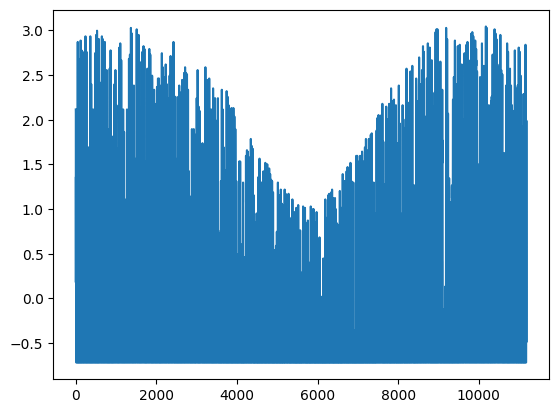

In [26]:
plt.plot(X_train_std)

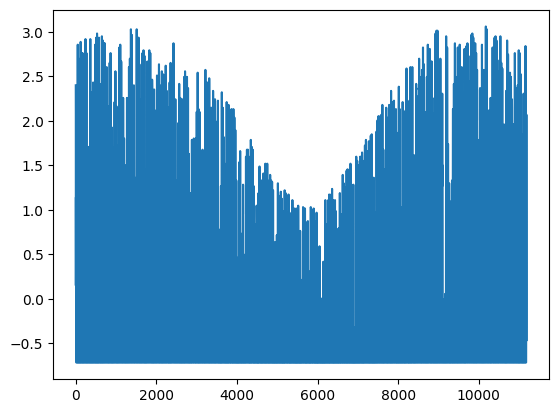

In [27]:
plt.plot(X_test_std)

In [5]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 16
model_num      = 1

#create the model
model = Sequential([
      keras.layers.Dense(n_neuron, activation=activation, input_shape=(X_train.shape[1],)),
      keras.layers.Dense(n_neuron, activation=activation),
      keras.layers.Dense(y_train.shape[1],  activation='linear')
])

model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


2022-12-05 01:59:53.171685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
print('\nInital test eval on different site:')
model.evaluate(X_test_std, y_test_std)

history = model.fit(X_train_std, y_train_std, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split = 0.4,
                    verbose         = 1,
                    callbacks       = [early_stop])

print('\nFinal test eval on different site:')
model.evaluate(X_test_std, y_test_std)



Inital test eval on different site:
350/350 [==============================] - 0s 434us/step - loss: 1.0974
Epoch 1/50
420/420 [==============================] - 0s 816us/step - loss: 0.4255 - val_loss: 0.2332
Epoch 2/50
420/420 [==============================] - 0s 751us/step - loss: 0.1239 - val_loss: 0.1261
Epoch 3/50
420/420 [==============================] - 0s 751us/step - loss: 0.0924 - val_loss: 0.1207
Epoch 4/50
420/420 [==============================] - 0s 750us/step - loss: 0.0903 - val_loss: 0.1199
Epoch 5/50
420/420 [==============================] - 0s 750us/step - loss: 0.0898 - val_loss: 0.1194
Epoch 6/50
420/420 [==============================] - 0s 776us/step - loss: 0.0894 - val_loss: 0.1189
Epoch 7/50
420/420 [==============================] - 0s 758us/step - loss: 0.0891 - val_loss: 0.1185
Epoch 8/50
420/420 [==============================] - 0s 752us/step - loss: 0.0888 - val_loss: 0.1185
Epoch 9/50
420/420 [==============================] - 0s 755us/step - loss:

0.15853244066238403

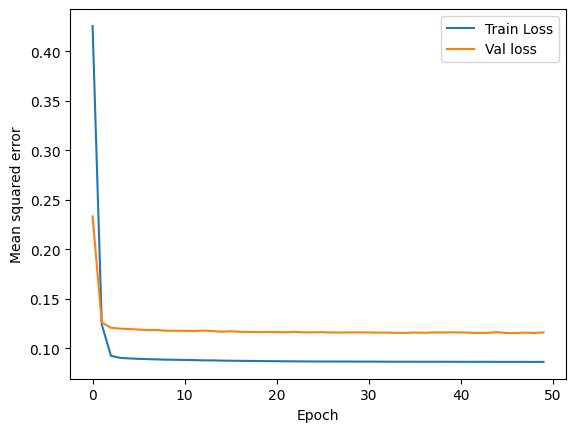

In [7]:
plot_history(history)

In [20]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))


#y_Test 
y_test_predict = model.predict(X_train_std)

df_test = pd.DataFrame()
df_test["x_test"] = X_test[:, 0]/3600
df_test["y_test"] = y_test[:, 0]
df_test["y_test_predict"] = y_test_predict

df_plot = df_test[100:200]
df_plot.head(20)

350/350 [==============================] - 0s 388us/step


,x_test,y_test,y_test_predict
100,225.044449,291.339308,0.195246
101,241.711105,136.980442,0.225185
102,145.877777,73.331258,-0.137469
103,29.211111,14.255590,-0.556283
104,0.044444,7.966870,-0.665993
105,0.044444,7.966870,-0.665993
106,0.044444,7.966870,-0.665993
107,0.044444,7.966870,-0.665993
108,0.044444,7.966870,-0.665993
109,0.044444,7.966870,-0.665993


Text(0, 0.5, 'y')

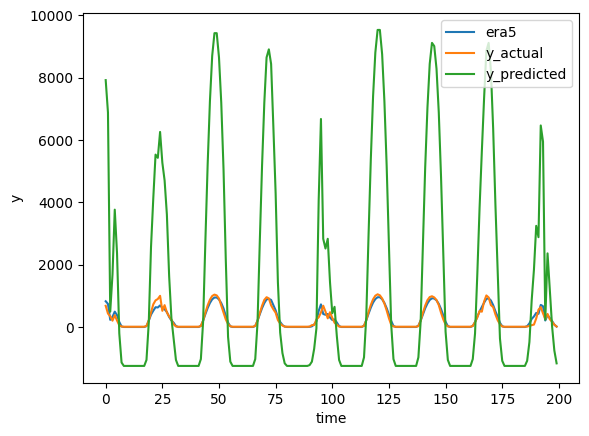

In [17]:
df_plot = df_test[0:200]
plt.plot(df_plot.x_test,label="era5")
plt.plot(df_plot.y_test,label="y_actual")
plt.plot(df_plot.y_test_predict,label="y_predicted")
plt.xlabel("time")
plt.legend()
plt.ylabel("y")

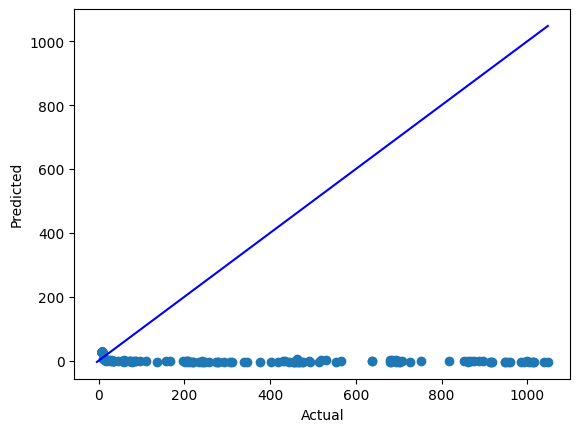

In [225]:
plt.scatter(x=df_plot.y_test,y=df_plot.y_test_predict)
p1 = max(max(df_plot.y_test_predict), max(df_plot.y_test))
p2 = min(min(df_plot.y_test_predict), min(df_plot.y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()


In [122]:
plt.figure(figsize=(10,4))
df_plot = df_test[0:200]
plt.plot(df_plot.y_actual,label="actual")
plt.plot(df_plot.y_predict,label="predict")
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'y_actual'

<Figure size 1000x400 with 0 Axes>